In [18]:
import os
import time
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np
import pickle
from copy import deepcopy

from data_preprocessing import get_all_data
from utils import f1, accuracy, split_data

RUNS_PATH = "data_clean/runs"

In [19]:
def load_results(file_subpath):
    with open(os.path.join(RUNS_PATH, file_subpath), "rb") as f:
        return pickle.load(f)

In [24]:
### load results
results = load_results("2024-10-28_22-11-30/All_columns__Logistic_Regression__results.pkl")
logreg = results["Logistic Regression"]

results = load_results("2024-10-28_22-11-30/Selected_columns_+_All_columns_PCA__Logistic_Regression__results.pkl")
svm = results["SVM"]

results = load_results("2024-10-31_14-44-57/All_columns__Ridge_Regression__results.pkl")
ridge = results["Ridge Regression"]

In [ ]:
### load results
all_results = defaultdict(dict)
run_names = [
    "2024-10-31_03-18-13",
    "2024-10-31_09-55-10",
    "2024-10-31_12-16-37",
    "2024-10-31_17-16-37",
]

for run_name in run_names:
    files = [f for f in os.listdir(os.path.join(RUNS_PATH, run_name)) if f.endswith("results.pkl")]

    ### collect test scores
    for f in files:
        data_name = f.split("__")[0]
        results = load_results(run_name + "/" + f)
        for model_name, res in results.items():
            if model_name not in all_results[data_name]:
                all_results[data_name][model_name] = []
            all_results[data_name][model_name].append(res["test_score"])

### print average and std
for data_name, models in all_results.items():
    print(data_name)
    for model_name, scores in models.items():
        print("  ", model_name, np.round(np.mean(scores),3), np.round(np.std(scores),3))

## Plotting scores

In [4]:
### grid search results
def get_2d_hps_grid(hps, val_scores, get_hp_to_plot_1, get_hp_to_plot_2):
    uniq_1 = np.unique([get_hp_to_plot_1(hp) for hp in hps])
    uniq_2 = np.unique([get_hp_to_plot_2(hp) for hp in hps])
    grid_sum = np.zeros((len(uniq_1), len(uniq_2)))
    grid_seen_n = np.zeros((len(uniq_1), len(uniq_2)))
    for i, (hp, score) in enumerate(zip(hps, val_scores)):
        grid_sum[
            np.where(uniq_1 == get_hp_to_plot_1(hp))[0][0],
            np.where(uniq_2 == get_hp_to_plot_2(hp))[0][0]
        ] += score
        grid_seen_n[
            np.where(uniq_1 == get_hp_to_plot_1(hp))[0][0],
            np.where(uniq_2 == get_hp_to_plot_2(hp))[0][0]
        ] += 1
    assert np.all(grid_seen_n > 0)
    grid = grid_sum / grid_seen_n
    return grid, uniq_1, uniq_2

In [5]:
### prepare logreg results
hps = logreg["hyperparam_search_list"]
val_scores = logreg["all_val_scores"]
logreg_get_hp_to_plot_1 = lambda hps_dict: hps_dict["class_weights"][1]
logreg_get_hp_to_plot_2 = lambda hps_dict: hps_dict["reg_mul"]
logreg["grid"], logreg["uniq_1"], logreg["uniq_2"] = get_2d_hps_grid(hps, val_scores, logreg_get_hp_to_plot_1, logreg_get_hp_to_plot_2)

In [6]:
### prepare svm results
hps = svm["hyperparam_search_list"]
val_scores = svm["all_val_scores"]
svm_get_hp_to_plot_1 = lambda hps_dict: hps_dict["class_weights"][1]
svm_get_hp_to_plot_2 = lambda hps_dict: hps_dict["_lambda"]
svm["grid"], svm["uniq_1"], svm["uniq_2"] = get_2d_hps_grid(hps, val_scores, svm_get_hp_to_plot_1, svm_get_hp_to_plot_2)

In [7]:
### prepare ridge reg results
hps = ridge["hyperparam_search_list"]
val_scores = ridge["all_val_scores"]
svm_get_hp_to_plot_1 = lambda hps_dict: hps_dict["class_weights"][1]
svm_get_hp_to_plot_2 = lambda hps_dict: hps_dict["reg_mul"]
ridge["grid"], ridge["uniq_1"], ridge["uniq_2"] = get_2d_hps_grid(hps, val_scores, svm_get_hp_to_plot_1, svm_get_hp_to_plot_2)

### remove last two hyperparam values from ridge
ridge["grid"] = ridge["grid"][:, :-2]
ridge["uniq_2"] = ridge["uniq_2"][:-2]

/tmp/ipykernel_13078/3910124194.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.885, 1]) # add space on the right for colorbar


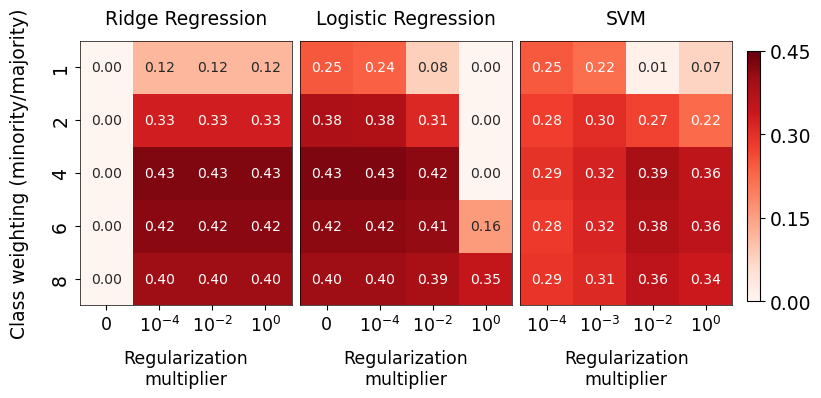

In [17]:
### plot heatmap of the validation scores wrt combination of two hyperparameters
fontsize = 13.5
logreg_xtick_labels = [r"$10^{{{}}}$".format(int(np.log10(x))) if x != 0 else "0" for x in logreg["uniq_2"]]
svm_xtick_labels = [r"$10^{{{}}}$".format(int(np.log10(x))) if x != 0 else "0" for x in svm["uniq_2"]]
ridge_xtick_labels = [r"$10^{{{}}}$".format(int(np.log10(x))) if x != 0 else "0" for x in ridge["uniq_2"]]

fig, axs = plt.subplots(1, 3, figsize=(8.5, 6))

### left
sns.heatmap(
    ridge["grid"],
    annot=True,
    fmt=".2f",
    cmap="Reds",
    ax=axs[0],
    cbar=False,
    annot_kws={"fontsize": 10},
    square=True,
    vmin=0,
    vmax=0.45
)
axs[0].set_title("Ridge Regression", fontsize=fontsize, pad=12)
axs[0].set_xlabel("Regularization\nmultiplier", fontsize=fontsize-1, labelpad=10)
axs[0].set_ylabel("Class weighting (minority/majority)", fontsize=fontsize, labelpad=16)
axs[0].set_xticks(np.arange(len(ridge["uniq_2"])) + 0.5)
axs[0].set_xticklabels(ridge_xtick_labels, fontsize=fontsize-1)
axs[0].set_yticks(np.arange(len(logreg["uniq_1"])) + 0.5)
axs[0].set_yticklabels(logreg["uniq_1"], fontsize=fontsize)
for spine in axs[0].spines.values():
    spine.set_visible(True)
    spine.set_linewidth(0.5)

### center
sns.heatmap(
    logreg["grid"],
    annot=True,
    fmt=".2f",
    cmap="Reds",
    ax=axs[1],
    cbar=False,
    annot_kws={"fontsize": 10},
    square=True,
    vmin=0,
    vmax=0.45
)
axs[1].set_title("Logistic Regression", fontsize=fontsize, pad=12)
axs[1].set_xlabel("Regularization\nmultiplier", fontsize=fontsize-1, labelpad=10)
axs[1].set_xticks(np.arange(len(logreg["uniq_2"])) + 0.5)
axs[1].set_xticklabels(logreg_xtick_labels, fontsize=fontsize-1)
axs[1].set_yticks([])
axs[1].set_yticklabels([])
for spine in axs[1].spines.values():
    spine.set_visible(True)
    spine.set_linewidth(0.5)

### right
im = axs[2].imshow(svm["grid"], cmap="Reds", vmin=0, vmax=0.45)
sns.heatmap(
    svm["grid"],
    annot=True,
    fmt=".2f",
    cmap="Reds",
    ax=axs[2],
    cbar=False,
    cbar_kws={"shrink": 0.8, "label": "Validation F1 score", "pad": 0.04},
    annot_kws={"fontsize": 10},
    square=True,
    vmin=0,
    vmax=0.45
)
axs[2].set_title("SVM", fontsize=fontsize, pad=12)
axs[2].set_xlabel("Regularization\nmultiplier", fontsize=fontsize-1, labelpad=10)
axs[2].set_xticks(np.arange(len(svm["uniq_2"])) + 0.5)
axs[2].set_xticklabels(svm_xtick_labels, fontsize=fontsize-1)
axs[2].set_yticks([])
axs[2].set_yticklabels([])
for spine in axs[2].spines.values():
    spine.set_visible(True)
    spine.set_linewidth(0.5)

### colorbar
cbar = fig.colorbar(im, ax=axs, fraction=0.019, pad=0)  # increased pad to avoid overlap
cbar.ax.tick_params(labelsize=fontsize)
cbar.locator = ticker.MaxNLocator(nbins=3)
# cbar.set_label("Validation F1 score", fontsize=fontsize, labelpad=18, rotation=270)

### adjust layout
fig.tight_layout(rect=[0, 0, 0.885, 1]) # add space on the right for colorbar
fig.subplots_adjust(wspace=0.04)
plt.show()

# save as pdf
# fig.savefig("hyperparam_search.pdf", bbox_inches="tight")

## Training analysis

In [233]:
cfg = {
    "raw_data_path": "data_raw",
    "clean_data_path": "data_clean",
    "allow_load_clean_data": False,
    "remap_labels_to_01": True,
    "seed": 0,
    "eval_frac": 0.2,
}

In [234]:
### get data
# x, x_final, y, ids, ids_final, col_idx_map, cleaned_col_idx_map = get_all_data(
#     cfg=cfg,
#     process_cols="all",
#     pca_kwargs=None,
#     verbose=False,
# )
# x_train, x_test, y_train, y_test = split_data(x=x, y=y, split_frac=0.2, seed=cfg["seed"])
(x_train, x_test), (y_train, y_test), (ids_train, ids_test), col_idx_map, cleaned_col_idx_map, (x_final, ids_final) = get_all_data(
    cfg=cfg,
    process_cols="all",
    pca_kwargs=None,
    standardize_num=True,
    onehot_cat=True,
    skip_rule_transformations=False,
    verbose=False,
)
sample_weights_train = np.array([logreg["hyperparams"]["class_weights"][yi] for yi in y_train])
sample_weights_test = np.array([logreg["hyperparams"]["class_weights"][yi] for yi in y_test])
print(f"x_train.shape: {x_train.shape}, x_test.shape: {x_test.shape}, y_train.shape: {y_train.shape}, y_test.shape: {y_test.shape}")

/home/keko24/workspace/epfl/ml/project1/ml-first-project/data_preprocessing.py:303: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(arr)
/home/keko24/miniforge3/envs/ml_aicrowd/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2053: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


x_train.shape: (262508, 939), x_test.shape: (65627, 939), y_train.shape: (262508,), y_test.shape: (65627,)


In [235]:
# Setup param update callback
def update_callback(w, x, y, epoch, model, **kwargs):
    reg_mul_before = model.reg_mul
    model.reg_mul = 0

    # Time tracking
    current_time = time.time()
    if hasattr(update_callback, 'genesis_time'):
        time_elapsed = current_time - update_callback.genesis_time
    else:
        time_elapsed = 0  # First call, so no time elapsed
        update_callback.genesis_time = current_time

    # Save the elapsed time to history
    history["time_elapsed"].append(time_elapsed)

    ### Loss
    history["train_loss"].append(model.log_reg_loss(
        x=x_train, y=y_train, w=w, sample_weights=sample_weights_train))
    history["test_loss"].append(model.log_reg_loss(
        x=x_test, y=y_test, w=w, sample_weights=sample_weights_test))

    ### F1
    y_hat_train = model.predict(x=x_train, w=w)
    history["train_f1"].append(f1(y_train, y_hat_train))
    y_hat_test = model.predict(x=x_test, w=w)
    history["test_f1"].append(f1(y_test, y_hat_test))

    history["w"].append(deepcopy(w))
    history["epoch"].append(epoch)

    model.reg_mul = reg_mul_before

In [236]:
### make a new hyperparams dict
new_hps = deepcopy(logreg["hyperparams"])
new_hps["optim_algo"] = "gd"
new_hps["optim_kwargs"] = {'epochs': 50}
# new_hps["optim_algo"] = "sgd"
# new_hps["optim_kwargs"] = {'epochs': 3, "batch_size": 256}
# new_hps["use_line_search"] = False
# new_hps["gamma"] = 1e-2
new_hps

{'gamma': None,
 'use_line_search': True,
 'optim_algo': 'gd',
 'optim_kwargs': {'epochs': 50},
 'class_weights': {0: 1, 1: 4},
 'reg_mul': 0,
 'verbose': False}

In [237]:
### train
history = defaultdict(list) # for tracking the optimization process
model = logreg["model_cls"](update_callback=update_callback, **new_hps)
model = model.fit(x_train, y_train)

In [238]:
### save for later
#history_lbfgs = deepcopy(history)
history_gd = deepcopy(history)
# history_sgd = deepcopy(history)

In [ ]:
fontsize = 22
linewidth = 2

# Create a single figure and axis
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot Loss on the left y-axis
line1, = ax1.plot(history_lbfgs["time_elapsed"], history_lbfgs["train_loss"], color="dodgerblue", linestyle="--", label="Train loss (L-BFGS)", linewidth=linewidth)
line2, = ax1.plot(history_lbfgs["time_elapsed"], history_lbfgs["test_loss"], color="dodgerblue", label="Test loss (L-BFGS)", linewidth=linewidth)
line3, = ax1.plot(history_gd["time_elapsed"], history_gd["train_loss"], color="navy", linestyle="--", label="Train loss (GD)", linewidth=linewidth)
line4, = ax1.plot(history_gd["time_elapsed"], history_gd["test_loss"], color="navy", label="Test loss (GD)", linewidth=linewidth)

# Label for the left y-axis (Loss)
ax1.set_xlabel("Time elapsed in seconds", fontsize=fontsize + 4, labelpad=20)
ax1.set_ylabel("Loss", fontsize=fontsize + 4, labelpad=20)
ax1.tick_params(axis="x", labelsize=fontsize + 4)
ax1.tick_params(axis="y", labelsize=fontsize + 4)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.set_ylim(0.35, 0.65)
ax1.set_xlim(0, min(history_lbfgs["time_elapsed"][-1], history_gd["time_elapsed"][-1]) - 1)

# Create a second y-axis for F1 metrics, sharing the same x-axis
ax2 = ax1.twinx()
line5, = ax2.plot(history_lbfgs["time_elapsed"], history_lbfgs["train_f1"], color="tab:red", linestyle="--", label="Train F1 (L-BFGS)", linewidth=linewidth)
line6, = ax2.plot(history_lbfgs["time_elapsed"], history_lbfgs["test_f1"], color="tab:red", label="Test F1 (L-BFGS)", linewidth=linewidth)
line7, = ax2.plot(history_gd["time_elapsed"], history_gd["train_f1"], color="darkred", linestyle="--", label="Train F1 (GD)", linewidth=linewidth)
line8, = ax2.plot(history_gd["time_elapsed"], history_gd["test_f1"], color="darkred", label="Test F1 (GD)", linewidth=linewidth)

# Label for the right y-axis (F1)
ax2.set_ylabel("F1", fontsize=fontsize + 4, labelpad=20)
ax2.tick_params(axis="y", labelsize=fontsize + 4)
ax2.spines["top"].set_visible(False)
ax2.set_ylim(0, 0.45)

fig.text(0.012, 0.63, "━", color="dodgerblue", fontsize=fontsize*2, va="center")
fig.text(0.012, 0.65, "━", color="navy", fontsize=fontsize*2, va="center")
fig.text(0.964, 0.60, "━", color="tab:red", fontsize=fontsize*2, va="center")
fig.text(0.964, 0.62, "━", color="darkred", fontsize=fontsize*2, va="center")

# Combine all lines for a single legend at the top
lines = [line1, line2, line3, line4, line5, line6, line7, line8]
labels = [line.get_label() for line in lines]
fig.legend(lines, labels, loc="upper center", fontsize=fontsize + 2, ncol=2, bbox_to_anchor=(0.5, 1.3))

fig.tight_layout()  # Adjust layout for clarity
fig.savefig("optim_algo_combined_loss_f1_comparison_top_legend.pdf", bbox_inches="tight", dpi=400)

plt.show()